By: Lincoln Schafer

As there is no findable database of per game player statistics for the MLB, we decided to attempt to compare team performance at altitude vs not at altitude.  Present is data for teams that played in Denver for every year that there has been an MLB team there, as well as the visiting teams' home statistics.

We can use χ2,  all  confidence,  max  confidence,  the  cosine  measure  aswell as lift to gauge the impact on elevation on every performance statistic

In [11]:
import sys
!conda install --yes --prefix {sys.prefix} pandasql

Solving environment: done

# All requested packages already installed.



In [233]:
#Importing necessary libraries
import sys
import pandas as p #dataframes to hold tables
from pandasql import sqldf #sql to dataframe conversion for data access
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
import os
import subprocess
from sklearn.model_selection import train_test_split
warnings.filterwarnings("ignore")

In [234]:
pysqldf = lambda q: sqldf(q, globals())
# Importing pre-processed data
df_elevations = p.read_csv('../altitudeData/elevations.csv')
df_teamsAtElevation = p.read_csv('../altitudeData/teamsAtElevation1993-2020.csv')
df_teamsAwayFromElevation = p.read_csv('../altitudeData/teamsAwayFromElevation1993-2020.csv')

In [235]:
df_teamsAtElevation.head(5)

,Rk,elevation,Team,Key,Year,SO,W,L,WL,ERA,...,BB.1,TB,GDP,HBP.1,SH,SF,IBB.1,BAbip,tOPS,sOPS
0,457,5183,ANA,ANA1997,1997,10,1,1,0.500,5.82,...,7,33,1,0,1,0,1,0.345,118,90
1,462,5183,ANA,ANA1999,1999,9,2,1,0.667,5.88,...,12,40,4,1,0,0,0,0.301,96,61
2,329,5183,ANA,ANA2001,2001,19,3,0,1.000,3.33,...,10,36,2,1,2,0,0,0.243,81,50
3,190,5183,ARI,ARI1998,1998,27,3,3,0.500,5.82,...,22,98,4,0,7,1,2,0.266,123,94
4,134,5183,ARI,ARI1999,1999,37,3,4,0.429,6.10,...,22,132,9,3,2,1,1,0.317,146,88


In [236]:
# teamStatsAtElevation = pysqldf("""
#     SELECT elevation, Team, Key, Year, (W + L) as G, WL, ERA, H, R, ER, HR, BB, IBB, ROE, SO, BF, WHIP, SOnine, SOBB, AB, twB, thB, BA, OBP, SLG, OPS, GDP, BAbip, tOPS, sOPS
#     FROM df_teamsAtElevation atElev
# """)

# teamStatsAwayFromElevation = pysqldf("""
#     SELECT elevation, Team, Key, Year, (W + L) as G, WL, ERA, H, R, ER, HR, BB, IBB, ROE, SO, BF, WHIP, SOnine, SOBB, AB, twB, thB, BA, OBP, SLG, OPS, GDP, BAbip, tOPS, sOPS
#     FROM df_teamsAwayFromElevation 
# """)

# Actually only need: elevation, WL, ERA, WHIP, BA, OBP, SLG, OPS, BAbip, tOPS, sOPS

teamStatsAtElevation = pysqldf("""
    SELECT elevation, WL, ERA, WHIP, BA, OBP, SLG, OPS, GDP, BAbip, tOPS, sOPS
    FROM df_teamsAtElevation atElev
""")

teamStatsAwayFromElevation = pysqldf("""
    SELECT elevation, WL, ERA, WHIP, BA, OBP, SLG, OPS, GDP, BAbip, tOPS, sOPS
    FROM df_teamsAwayFromElevation 
""")


# teamStatsAtElevation
# teamStatsAwayFromElevation



Stats I will be comparing: WL (Win Loss Percentage), ERA (Earned Run Average), WHIP (Walks And Hits Per Inning Pitched), BA (Batting Average), OBP (On Base Percentage), SLG (Sluggin Percentage) , OPS (OBP + SLG), BAbip (Batting Avg. on balls in play), tOPS (OPS for split relative to Player’s Total OPS), sOPS (OPS for split relative to League’s Split OPS)

In [237]:
# Isolation stats from both away and home to be able to compare easier
# We know that the row number corresponds to same team as the data was pre sorted this way
WLComparison = p.concat([teamStatsAtElevation['WL'], teamStatsAtElevation['elevation'], teamStatsAwayFromElevation['WL'], teamStatsAwayFromElevation['elevation']] , 1)
ERAComparison = p.concat([teamStatsAtElevation['ERA'], teamStatsAwayFromElevation['ERA']] , 1)
WHIPComparison = p.concat([teamStatsAtElevation['WHIP'], teamStatsAwayFromElevation['WHIP']] , 1)
BAComparison = p.concat([teamStatsAtElevation['BA'], teamStatsAwayFromElevation['BA']] , 1)
OBPComparison = p.concat([teamStatsAtElevation['OBP'], teamStatsAwayFromElevation['OBP']] , 1)
SLGComparison = p.concat([teamStatsAtElevation['SLG'], teamStatsAwayFromElevation['SLG']] , 1)
OPSComparison = p.concat([teamStatsAtElevation['OPS'], teamStatsAwayFromElevation['OPS']] , 1)
BAbipComparison = p.concat([teamStatsAtElevation['BAbip'], teamStatsAwayFromElevation['BAbip']] , 1)
tOPSComparison = p.concat([teamStatsAtElevation['tOPS'], teamStatsAwayFromElevation['tOPS']] , 1)
sOPSComparison = p.concat([teamStatsAtElevation['sOPS'], teamStatsAwayFromElevation['sOPS']] , 1)

In [238]:
# Renaming the columns in each data frame as they were identical
WLComparison.columns = ['wlAltitude', 'altElev', 'wlNoAltitude', 'noAltElev']
ERAComparison.columns = ['ERAAltitude', 'ERANoAltitude']
WHIPComparison.columns = ['WHIPAltitude', 'WHIPNoAltitude']
BAComparison.columns = ['BAAltitude', 'BANoAltitude']
OBPComparison.columns = ['OBPAltitude', 'OBPNoAltitude']
SLGComparison.columns = ['SLGAltitude', 'SLGNoAltitude']
OPSComparison.columns = ['OPSAltitude', 'OPSNoAltitude']
BAbipComparison.columns = ['BAbipAltitude', 'BAbipNoAltitude']
tOPSComparison.columns = ['tOPSAltitude', 'tOPSNoAltitude']
sOPSComparison.columns = ['sOPSAltitude', 'sOPSNoAltitude']

# WLComparison
# WHIPComparison

In [228]:
# WLComparions_ax = WLComparison.plot.scatter(x='wlNoAltitude',y='wlAltitude')
# ERAComparison_ax = ERAComparison.plot.scatter(x='ERANoAltitude',y='ERAAltitude')
# WHIPComparison_ax = WHIPComparison.plot.scatter(x='WHIPNoAltitude',y='WHIPAltitude')
# BAComparison_ax = BAComparison.plot.scatter(x='BANoAltitude',y='BAAltitude')
# OBPComparison_ax = OBPComparison.plot.scatter(x='OBPNoAltitude',y='OBPAltitude')
# SLGComparison_ax = SLGComparison.plot.scatter(x='SLGNoAltitude',y='SLGAltitude')
# OPSComparison_ax = OPSComparison.plot.scatter(x='OPSNoAltitude',y='OPSAltitude')
# BAComparison_ax = BAComparison.plot.scatter(x='BANoAltitude',y='BAAltitude')
# tOPSComparison_ax = tOPSComparison.plot.scatter(x='tOPSNoAltitude',y='tOPSAltitude')
# sOPSComparison_ax = sOPSComparison.plot.scatter(x='sOPSNoAltitude',y='sOPSAltitude')

In [239]:
# awayFromElevation_ax = teamStatsAwayFromElevation.plot.scatter(x="elevation", y="WL")
# atElevation_ax = teamStatsAtElevation.plot.scatter(x="elevation", y="WL")
allData = p.concat([teamStatsAtElevation, teamStatsAwayFromElevation])

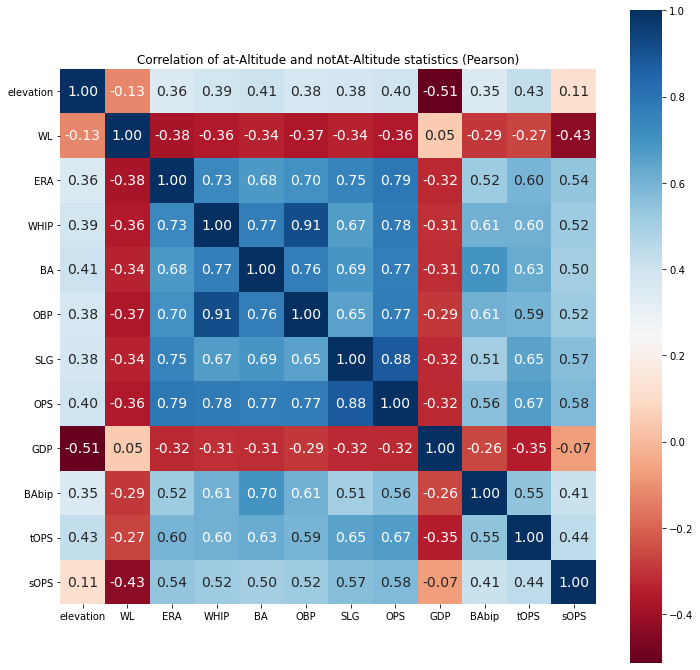

In [266]:
corrPearson = allData.corr(method = 'pearson')
plt.figure(figsize=(12,12))
sns.heatmap(corrKendall, square = True, annot = True, fmt = '.2f', annot_kws = {'size': 14}, \
            cmap = 'RdBu')
plt.title('Correlation of at-Altitude and notAt-Altitude statistics (Pearson)')
plt.show()

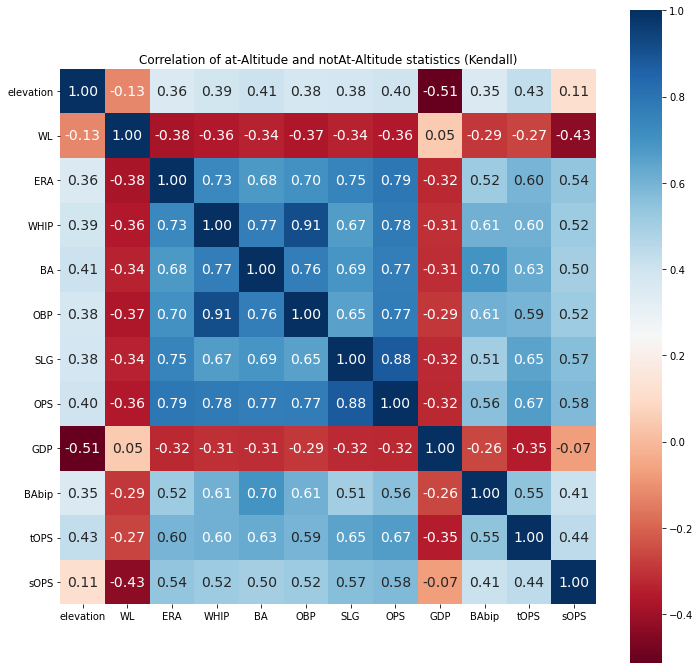

In [263]:
corrKendall = allData.corr(method = 'kendall')
plt.figure(figsize=(12,12))
sns.heatmap(corrKendall, square = True, annot = True, fmt = '.2f', annot_kws = {'size': 14}, \
            cmap = 'RdBu')
plt.title('Correlation of at-Altitude and notAt-Altitude statistics (Kendall)')
plt.show()

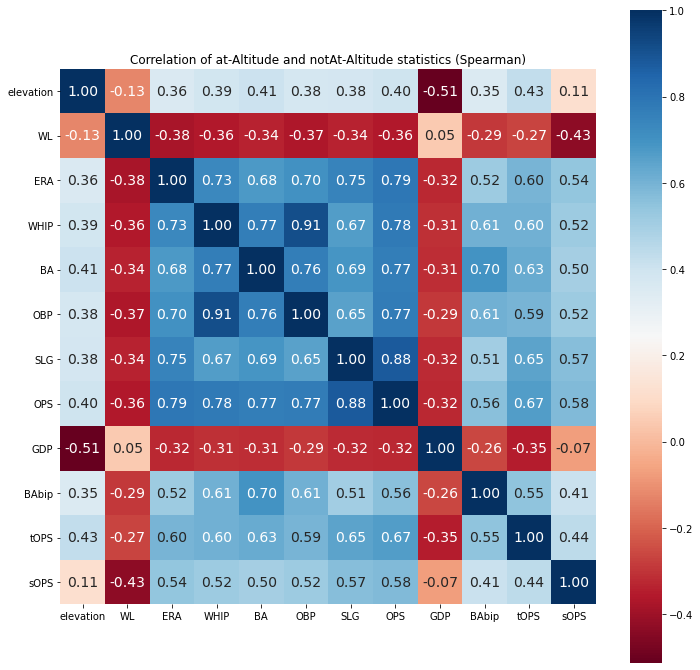

In [262]:
corrSpearman = allData.corr(method = 'spearman')
plt.figure(figsize=(12,12))
sns.heatmap(corrKendall, square = True, annot = True, fmt = '.2f', annot_kws = {'size': 14}, \
            cmap = 'RdBu')
plt.title('Correlation of at-Altitude and notAt-Altitude statistics (Spearman)')
plt.show()